In [1]:
%matplotlib inline
import hashlib
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


D = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

N = 1024
Z = 8
GAM = 1

M = len(D)

MAX_ITER = 1000

def hamming(x_k, x_l):
    return np.mean(x_k != x_l)

In [2]:
class Encoder(object):
    
    
    def __init__(self, seed, d, n, z, gam):
        self.seed = seed
        self.d = d
        self.m = len(d)
        
        self.n = n
        self.z = z
        self.gam = gam
        
        # sample basis and mask function aux var
        np.random.seed(seed)
        self.x_star = np.random.randint(0, z, n)
        self.xs = [np.random.randint(0, z, n) for i in range (self.m)]
        
        self.seed_offset = np.random.randint(0, 2**32-1)
    
    
    def veil(self, x_k, x_l):
        # get unique RNG seed from x_k and x_l
        str_repr = ''.join(x_k.astype(str)) + ''.join(x_l.astype(str))
        rng_seed = int(hashlib.sha256(str_repr.encode('utf-8')).hexdigest(), 16)  % 10**9
        
        np.random.seed((rng_seed + self.seed_offset)%(2**32))
        
        return np.random.rand(len(x_k))
    
    
    def weave(self, x_k, x_l, t):
        mask = self.veil(x_k, x_l) < 1/(t+1)**self.gam
        u = x_k.copy()
        u[mask] = x_l[mask]
        return u
    
    
    def encode(self, s):
        y = self.x_star.copy()
        
        for t_, a in enumerate(s):
            t = t_+1
            idx = self.d.index(a)
            y = self.weave(y, self.xs[idx], t)
            
        return y
    
    
    # functions for exact calculation
    def smty_seq_sbl(self, y, s_i):
        if self.gam != 1:
            raise NotImplementedError
        
        n_i = np.sum(np.array([y_ for y_ in y], dtype='<U1') == s_i)
        l = len(y)
        
        q = n_i/(l+1) + (1/self.z) * (l + 1 - n_i)/(l + 1)

        return q, q*(1-q)/self.n
    
    
    def smty_seq_seq(self, y, y_):
        if self.gam != 1:
            raise NotImplementedError
        
        # get seq lens and shared starting subseq len (t)
        l = len(y)
        l_ = len(y_)
        t = 0
        for s, s_ in zip(y, y_):
            if s == s_:
                t += 1
            else:
                break
        
        assert np.all(y[:t] == y_[:t])
        
        # convert seqs to arrays
        y = np.array([yy for yy in y], dtype='<U1')
        y_ = np.array([yy for yy in y_], dtype='<U1')

        # get symbol count vecs
        n_u = [np.sum(y[:t] == self.d[i]) for i in range(self.m)]
        n_v = [np.sum(y[t:] == self.d[i]) for i in range(self.m)]
        n_v_ = [np.sum(y_[t:] == self.d[i]) for i in range(self.m)]
        
        # calc case probabilites from ms section 4.2
        p_1 = (t+1)**2 / ((l+1)*(l_+1))
        
        p_2 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_v_) + ((l-t)*(l_-t) - np.dot(n_v, n_v_)) * (1/self.z) )
        
        p_3 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_u, n_v_) + ((t+1)*(l_-t) - np.dot(n_u, n_v_)) * (1/self.z) )
        
        p_4 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_u) + ((l-t)*(t+1) - np.dot(n_v, n_u)) * (1/self.z) )
        
        # sum case probabilities
        q = p_1 + p_2 + p_3 + p_4
        
        return q, q*(1-q)/self.n
    
    
class Decoder(object):
    
    def __init__(self, encoder):
        self.e = encoder
        
    
    def decode(self, y, l=None, return_dst=False, force=None, max_iter=MAX_ITER):
        
        # get set of elements in sequence
        min_idxs = np.argsort([hamming(x, y) for x in self.e.xs])
        vs = [self.e.xs[idx] for idx in min_idxs]
        
        # reconstruct sequence
        y_star = self.e.x_star.copy()
        s_hat = ''
        dst = [hamming(y_star, y)]
        
        for t in range(1, max_iter):
            
            us = [self.e.weave(y_star, v, t) for v in vs]
            dst_ = [hamming(u, y) for u in us]
            j = np.argmin(dst_)
            
            if l is None and dst_[j] >= dst[-1]:
                break

            if force is not None and len(force) >= t:
                next_sym = force[t-1]
                next_x = self.e.xs[self.d.index(next_sym)]
            else:
                next_sym = self.e.d[min_idxs[j]]
                next_x = vs[j]

            s_hat += next_sym
            y_star = self.e.weave(y_star, next_x, t)
            dst.append(hamming(y_star, y))
            
            if t == l:
                break

        if not return_dst:
            return s_hat
        else:
            return s_hat, np.array(dst)

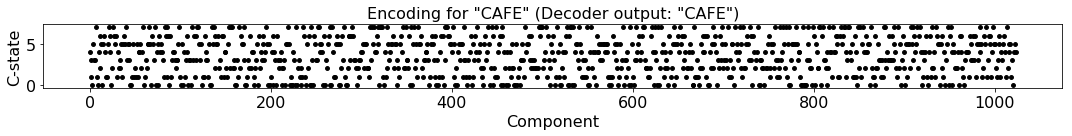

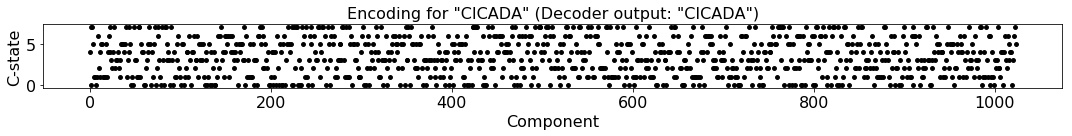

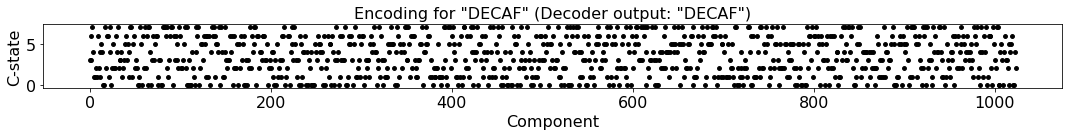

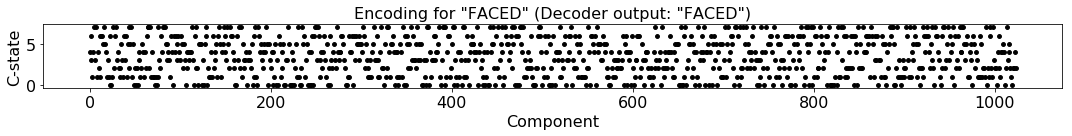

In [3]:
encoder = Encoder(0, D, N, Z, GAM)
decoder = Decoder(encoder)

for y in ['CAFE', 'CICADA', 'DECAF', 'FACED']:

    x = encoder.encode(y)
    fig, ax = plt.subplots(1, 1, figsize=(15, 2), tight_layout=True)
    ax.scatter(range(len(x)), x, s=15, c='k')
    ax.set_xlabel('Component')
    ax.set_ylabel('C-state')
    ax.set_title('Encoding for "{}" (Decoder output: "{}")'.format(y, decoder.decode(x)))
    set_font_size(ax, 16)

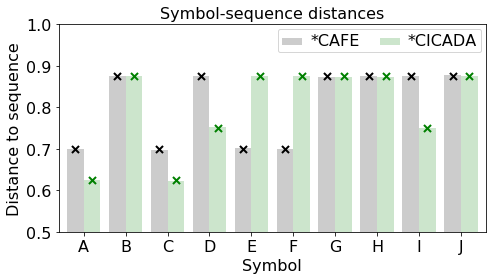

In [4]:
# plot expected and true seq-symbol similarities for two diff seqs
N_TRIALS = 100
X_LIM = (-1, 10)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
hs = []

for y, c, x_off in zip(['CAFE', 'CICADA'], ['k', 'g'], [-.2, .2]):
    # generate simulated similarities
    dst = np.nan * np.zeros((N_TRIALS, len(D)))
    
    for seed in range(N_TRIALS):
        encoder = Encoder(seed, D, N, Z, GAM)
        x = encoder.encode(y)
        dst[seed] = [hamming(x, encoder.xs[i]) for i in range(encoder.m)]
    
    h = ax.bar(np.arange(len(D)) + x_off, dst.mean(0), width=.4, color=c, alpha=.2, label='*' + y)
    
    # plot exact distances
    dst_exact = [1 - encoder.smty_seq_sbl(y, s_)[0] for s_ in D]
    ax.scatter(np.arange(len(dst_exact)) + x_off, dst_exact, c=c, s=50, marker='x', lw=2)
    hs.append(h)

ax.set_xlim(X_LIM[0]+.4, X_LIM[1]-.4)
ax.set_ylim(.5, 1)

ax.set_xticks(range(X_LIM[1]))
ax.set_xticklabels(D[:X_LIM[1]])

ax.set_xlabel('Symbol')
ax.set_ylabel('Distance to sequence')
ax.set_title('Symbol-sequence distances')

ax.legend(handles=hs, ncol=2)

set_font_size(ax, 16)

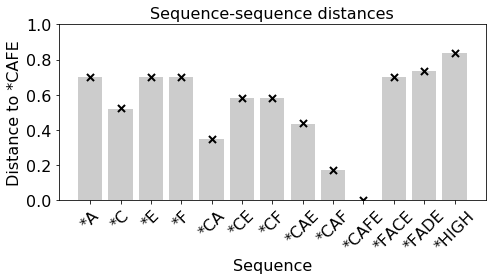

In [5]:
# plot expected and true seq-seq similarities
N_TRIALS = 100
y = 'CAFE'
y_s = ['A', 'C', 'E', 'F', 'CA', 'CE', 'CF', 'CAE', 'CAF', 'CAFE' ,'FACE', 'FADE', 'HIGH']

dst = np.nan * np.zeros((N_TRIALS, len(y_s)))

for seed in range(N_TRIALS):
    encoder = Encoder(seed, D, N, Z, GAM)
    
    x = encoder.encode(y)
    
    dst[seed] = [hamming(x, encoder.encode(y_)) for y_ in y_s]
    
dst_exact = [1 - encoder.smty_seq_seq(y, y_)[0] for y_ in y_s]

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

ax.bar(np.arange(len(y_s)), dst.mean(0), width=.8, color='k', alpha=.2)
ax.scatter(np.arange(len(y_s)), dst_exact, c='k', s=50, marker='x', lw=2)

ax.set_ylim(0, 1)

ax.set_xticks(np.arange(len(y_s)))
ax.set_xticklabels(['*' + y_ for y_ in y_s], rotation=45)
ax.set_xlabel('Sequence')
ax.set_ylabel('Distance to *{}'.format(y))
ax.set_title('Sequence-sequence distances')
set_font_size(ax, 16)

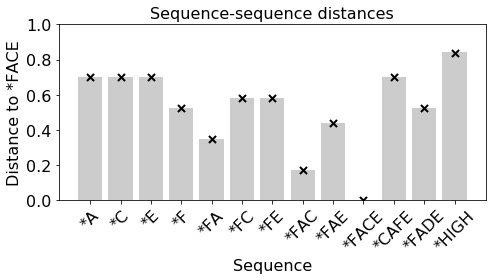

In [6]:
# plot expected and true seq-seq similarities
N_TRIALS = 100
y = 'FACE'
y_s = ['A', 'C', 'E', 'F', 'FA', 'FC', 'FE', 'FAC', 'FAE', 'FACE', 'CAFE', 'FADE', 'HIGH']

dst = np.nan * np.zeros((N_TRIALS, len(y_s)))

for seed in range(N_TRIALS):
    encoder = Encoder(seed, D, N, Z, GAM)
    
    x = encoder.encode(y)
    
    dst[seed] = [hamming(x, encoder.encode(y_)) for y_ in y_s]
    
dst_exact = [1 - encoder.smty_seq_seq(y, y_)[0] for y_ in y_s]

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

ax.bar(np.arange(len(y_s)), dst.mean(0), width=.8, color='k', alpha=.2)
ax.scatter(np.arange(len(y_s)), dst_exact, c='k', s=50, marker='x', lw=2)

ax.set_ylim(0, 1)

ax.set_xticks(np.arange(len(y_s)))
ax.set_xticklabels(['*' + y_ for y_ in y_s], rotation=45)
ax.set_xlabel('Sequence')
ax.set_ylabel('Distance to *{}'.format(y))
ax.set_title('Sequence-sequence distances')
set_font_size(ax, 16)

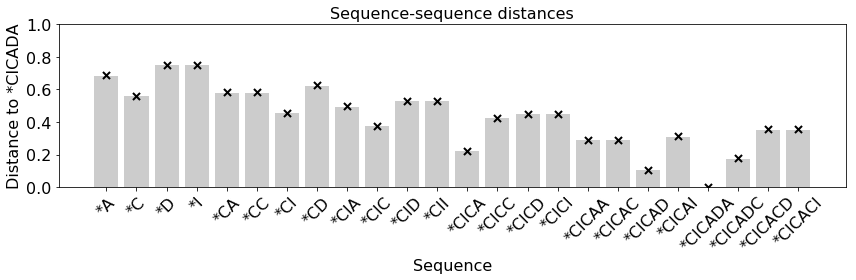

In [7]:
# plot expected and true seq-seq similarities
N_TRIALS = 100
y = 'CICADA'
y_s = [
    'A', 'C', 'D', 'I', 'CA', 'CC', 'CI', 'CD',
    'CIA', 'CIC', 'CID', 'CII',
    'CICA', 'CICC', 'CICD', 'CICI',
    'CICAA', 'CICAC', 'CICAD', 'CICAI',
    'CICADA', 'CICADC', 'CICACD', 'CICACI'
]

dst = np.nan * np.zeros((N_TRIALS, len(y_s)))

for seed in range(N_TRIALS):
    encoder = Encoder(seed, D, N, Z, GAM)
    
    x = encoder.encode(y)
    
    dst[seed] = [hamming(x, encoder.encode(y_)) for y_ in y_s]
    
dst_exact = [1 - encoder.smty_seq_seq(y, y_)[0] for y_ in y_s]

fig, ax = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)

ax.bar(np.arange(len(y_s)), dst.mean(0), width=.8, color='k', alpha=.2)
ax.scatter(np.arange(len(y_s)), dst_exact, c='k', s=50, marker='x', lw=2)

ax.set_ylim(0, 1)

ax.set_xticks(np.arange(len(y_s)))
ax.set_xticklabels(['*' + y_ for y_ in y_s], rotation=45)
ax.set_xlabel('Sequence')
ax.set_ylabel('Distance to *{}'.format(y))
ax.set_title('Sequence-sequence distances')
set_font_size(ax, 16)

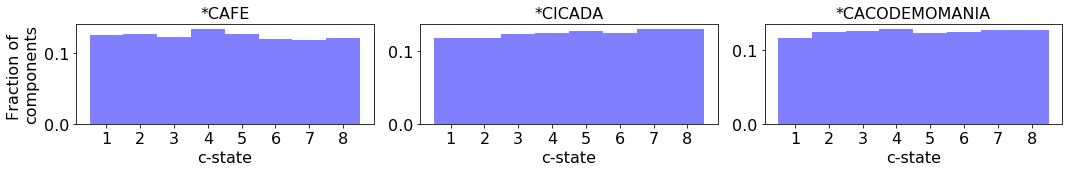

In [15]:
# plot c-state distribution for different sequences
ys = ['CAFE', 'CICADA', 'CACODEMOMANIA']
fig, axs = plt.subplots(1, 3, figsize=(15, 2.5), tight_layout=True)
axs = axs.flatten()

encoder = Encoder(0, D, 4*N, Z, GAM)
xs = []

for y, ax in zip(ys, axs):
    x = encoder.encode(y)
    bins = np.arange(Z+1) - .5
    ax.hist(x, bins, color='b', alpha=.5, normed=True)
    
    ax.set_title('*' + y)

axs[0].set_ylabel('Fraction of \ncomponents')

for ax in axs:
    ax.set_xlabel('c-state')
    ax.set_xticks(np.arange(Z))
    ax.set_xticklabels(1 + np.arange(Z))
    ax.set_yticks([0, .1])

    set_font_size(ax, 16)

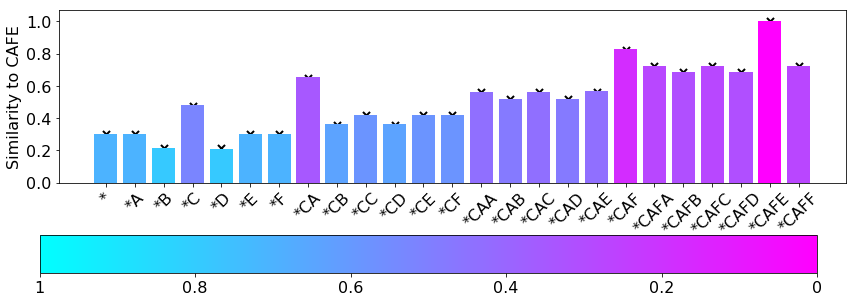

In [9]:
# plot expected and true seq-seq similarities
N_TRIALS = 100
y = 'CAFE'
y_s = [
    '', 'A', 'B', 'C', 'D', 'E', 'F',
    'CA', 'CB', 'CC', 'CD', 'CE', 'CF',
    'CAA', 'CAB', 'CAC', 'CAD', 'CAE', 'CAF',
    'CAFA', 'CAFB', 'CAFC', 'CAFD', 'CAFE', 'CAFF',
]

smty = np.nan * np.zeros((N_TRIALS, len(y_s)))

for seed in range(N_TRIALS):
    encoder = Encoder(seed, D, N, Z, GAM)
    
    x = encoder.encode(y)
    
    smty[seed] = [1 - hamming(x, encoder.encode(y_)) for y_ in y_s]
    
smty_exact = [encoder.smty_seq_seq(y, y_)[0] for y_ in y_s]


fig, ax = plt.subplots(1, 1, figsize=(12, 3.5), tight_layout=True)

ax.bar(np.arange(len(y_s)), smty.mean(0), width=.8, color=cm.cool(smty.mean(0)), alpha=1)
ax.scatter(np.arange(len(y_s)), smty_exact, c='k', s=50, marker='x', lw=2)

ax.set_xticks(np.arange(len(y_s)))
ax.set_xticklabels(['*' + y_ for y_ in y_s], rotation=45)
ax.set_ylabel('Similarity to {}'.format(y))
set_font_size(ax, 16)

sm = ScalarMappable(cmap=plt.cm.get_cmap('cool'), norm=plt.Normalize(0, 1))
sm.set_array([])

cax = fig.add_axes([0.05, -0.1, .9, 0.15])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')

cax.set_xticklabels([1, .8, .6, .4, .2, 0])
set_font_size(cax, 16)